## A _Hebbian_-trained NN classifier for **frogs** and **airplanes** from CIFAR-10

Isidoros Tsaousis-Seiras, AEM: 10042, THMMY
[github repository](https://github.com/isidorostsa/svm-cifar)

In [1]:
import numpy as np
from numpy import linalg
from sklearn.metrics import accuracy_score
# pca
from sklearn.decomposition import PCA

from itertools import product

import matplotlib.pyplot as plt

import time
import random
from matplotlib.ticker import MaxNLocator

from helpers import *

In [2]:
trainset, testset = fetch_datasets()
cifar_len = len(trainset)
models = {}

x_train, y_train = trainset.data, trainset.targets
x_test, y_test = testset.data, testset.targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

Files already downloaded and verified


The subject of this report is to train an `SVM` model to distinguish between animals and vehicles in the `CIFAR-10` dataset. The dataset consist of an equal number of each of the following categories: airplanes, cars, cats, dogs, frogs, horses, ships, and trucks.

There are 6 animals and 4 vehicles in the sets, so to have an equal number of animals and vehicles **we will disregard birds and deer** (categories chosen randomly).

We will give label = `-1` for vehicles and label = `1` for animals

The vehicles will have a label of `-1` and the animals `1`. This is required by the `SVM` implementation.

In [3]:
labels = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
}

# only keep frog and airplane
keep = [
    "airplane",
    # "automobile",
    # "bird",
    # "cat",
    # "deer",
    # "dog",
    # "frog"
    "horse",
    # "ship",
    "truck",
]

remove = [num for label, num in labels.items() if label not in keep]

num_classes = len(keep)

# Create a mask for y_train and y_test
mask_train = [y not in remove for y in y_train]
mask_test = [y not in remove for y in y_test]

# Apply the mask to y_train and y_test
y_train = [y for y, m in zip(y_train, mask_train) if m]
y_test = [y for y, m in zip(y_test, mask_test) if m]

# Apply the mask to x_train and x_test
x_train = x_train[mask_train]
x_test = x_test[mask_test]

# flatten data
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

# normalize data
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

assert x_test.shape == (1000*(10-len(remove)), 32*32*3)
assert x_train.shape == (5000*(10-len(remove)), 32*32*3)

In [4]:
# notmalize data
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

Before implementing the svm, we will trim the features using PCA of various degrees. First we will review the generated images optically.

In [9]:
pcas = {i: PCA(n_components=0.9+0.01*i) for i in range(1, 10, 3)}

for pca in pcas.values():
   pca.fit(x_train)

We can inspect how well the compression is done by performing a transformation and then reversing that.

PCA with 90% of the explained variance, with 121 components


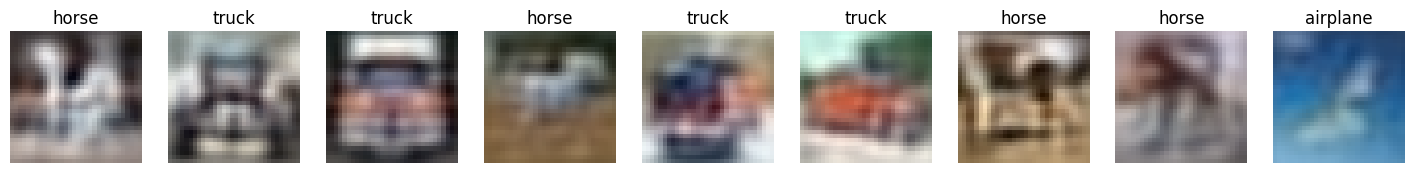

PCA with 91% of the explained variance, with 188 components


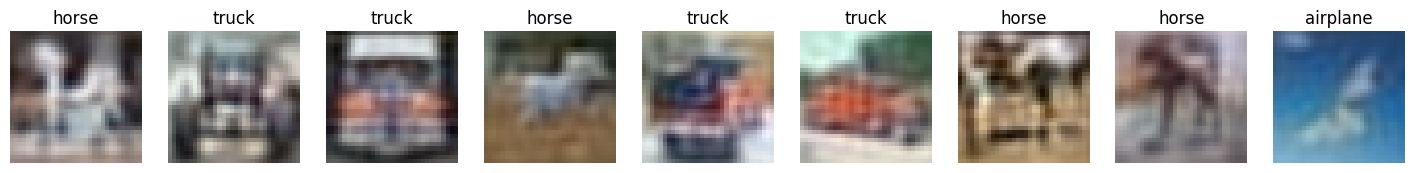

PCA with 92% of the explained variance, with 337 components


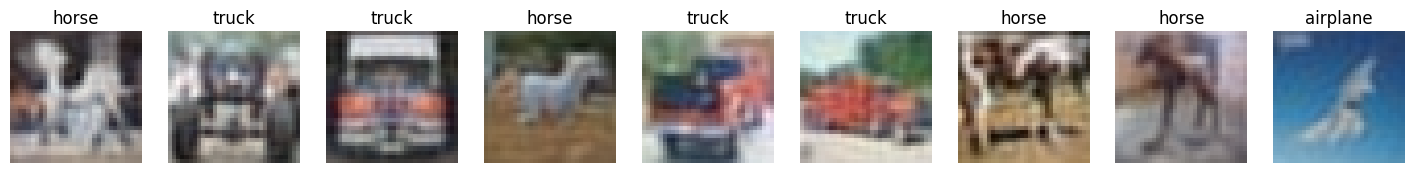

In [10]:
idx = random.randint(0, len(x_test)-9)

for i, pca in enumerate(pcas.values()):
    print(f"PCA with {90+i}% of the explained variance, with {pca.n_components_} components")
    show_reconstruction(pca, x_test, y_test, testset.classes, n=9, index=idx)

First we will define a model that saves the neccessary information on the forward pass to train with Hebbian-type rules.

In [5]:
class FullyConnectedNN(nn.Module):
    # layer_sizes is a list of the sizes of the layers
    def __init__(self, layer_sizes = [32*32*3, 100, 2], activation=nn.ReLU()):
        super(FullyConnectedNN, self).__init__()
        self.activations = []

        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                layers.append(activation)

        self.layers = nn.ModuleList(layers)

        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.01)

    def forward(self, x):
        # We keep track of the activations for the Hebbian update
        self.activations = [x] 
        for layer in self.layers:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                self.activations.append(x)

        return x


In [6]:
# returns the updated weights based on the old weights and the activations
def hebbian_update(weights, activations, learning_rate=0.01):
    # We increment based on the outer product of the activations
    # The element at (i, j) is the product of the i-th activation with the j-th activation
    # So if they are large together, the weight will be increased
    # and in the resulting matrix (i, j) will be the weight between the i-th and j-th neuron

    # this is done on each layer
    hebbian_increment = torch.ger(activations[0], activations[1])
    return weights + learning_rate * hebbian_increment.T

In [7]:
def test_model(net, x_test, y_test):

    clusters = [
        [] for _ in range(net.layers[-1].out_features)
    ]

    net.eval()

    for data, target in zip(x_test, y_test):
        data = torch.tensor(data, dtype=torch.float32, device=device)

        output = net(data)
        predicted = torch.argmax(output)
        clusters[predicted].append(target)

    net.train()


    clusters_to_labels = {}
    # assign the most common label to each cluster
    for i, cluster in enumerate(clusters):
        if cluster:
            clusters_to_labels[i] = max(set(cluster), key=cluster.count)
        else:
            clusters_to_labels[i] = -1

    # count the number of correct predictions
    correct = 0
    for i, cluster in enumerate(clusters):
        for label in cluster:
            if clusters_to_labels[i] == label:
                correct += 1
    

    return correct / len(y_test)



def hebbian_train(net, x_train, y_train, x_test_in=x_test, y_test_in=y_test, his=None, epochs=5, learning_rate=0.00000005, update_rule=hebbian_update, weight_decay=0, hebbnet=None):
    if his:
        history = his
    else:
        history = []

    now = time.time()
    quit = False
    holdout = 3
    divergence_threshold = 1e30

    if hebbnet is not None:
        hebbnet_per_layer = {}
        layer_idx = 0
        for layer in net.layers:
            if isinstance(layer, nn.Linear):
                layer_idx += 1

                hebbnet_per_layer[layer_idx] = hebbnet(layer.weight.data)



    epoch_0 = len(history)
    
    for epoch in range(epoch_0, epoch_0 + epochs):
        total = 0

        # for data, target in zip(x_train, y_train):
        # iterate over the data in random order
        ran_idx_list = list(range(len(x_train)))
        random.shuffle(ran_idx_list)

        for idx in ran_idx_list:
            data = x_train[idx]
            # Forward pass
            data = torch.tensor(data, dtype=torch.float32, device=device)

            net.zero_grad()
            output = net(data)

            if total == 0:
                mag = max(output.data).item()
                # check if any magnitude is nan
                if np.isnan(mag):
                    print("Magnitude diverged, quitting")
                    quit = True
                    holdout = 0
                if mag > divergence_threshold:
                    print(f"Magnitude diverged, quitting in {holdout} epochs")
                    quit = True

                history.append({})
                history[epoch]["magnitude"] = mag
            total += 1

            # Hebbian update for each layer
            layer_idx = 0
            for layer in net.layers:
                if isinstance(layer, nn.Linear):
                    # Get pre-synaptic and post-synaptic activations
                    pre_activation = net.activations[layer_idx]
                    post_activation = net.activations[layer_idx + 1]
                    layer_idx += 1

                    # Hebbian update
                    if hebbnet is None:
                        layer.weight.data = update_rule(layer.weight.data, [pre_activation, post_activation], learning_rate) * (1 - weight_decay)
                    else:
                        layer.weight.data = hebbnet_per_layer[layer_idx](layer.weight.data, [pre_activation, post_activation], learning_rate) * (1 - weight_decay)


        classes_amount = net.layers[-1].out_features
        baseline = 1 / classes_amount

        net.eval()
        train_accuracy = test_model(net, x_train, y_train)

        test_accuracy = test_model(net, x_test_in, y_test_in)
        net.train()

        history[epoch]["train_accuracy"] = train_accuracy
        history[epoch]["test_accuracy"] = test_accuracy

        if quit:
            holdout -= 1
            if holdout <= 0:
                break

        print(f"Epoch {epoch+1} - Test accuracy: {history[epoch]['test_accuracy']}, Train accuracy: {history[epoch]['train_accuracy']} - Magnitude: {history[epoch]['magnitude']}, Time: {time.time() - now}")
        now = time.time()

    return history


This model is trained using unsupervised learning, so we cannot know what output corresponds to which class beforehand. Accuracy will be gauged based on how well the model can tell the classes apart. The baseline is 50%.

In [10]:
# returns the updated weights based on the old weights and the activations
def hebbian_update(weights, activations, learning_rate=0.01):
    # We increment based on the outer product of the activations
    # The element at (i, j) is the product of the i-th activation with the j-th activation
    # So if they are large together, the weight will be increased
    # and in the resulting matrix (i, j) will be the weight between the i-th and j-th neuron

    # this is done on each layer
    hebbian_increment = torch.ger(activations[0], activations[1])
    return weights + learning_rate * hebbian_increment.T

net = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
# initialize weights
net.to(device)
history_lr_1e7 = hebbian_train(net, x_train, y_train, epochs=50, learning_rate=1e-7)


net = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
# initialize weights
net.to(device)
history_lr_1e8 = hebbian_train(net, x_train, y_train, epochs=50, learning_rate=1e-8)



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 576.00 KiB is free. Including non-PyTorch memory, this process has 3.81 GiB memory in use. Of the allocated memory 3.73 GiB is allocated by PyTorch, and 8.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [45]:
net = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net.to(device)

history_lr_1e6_wd_1e5 = hebbian_train(net, x_train, y_train, epochs=100, learning_rate=1e-6, weight_decay=1e-5)

net = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net.to(device)
history_lr_1e6_wd_1e4 = hebbian_train(net, x_train, y_train, epochs=6, learning_rate=1e-6, weight_decay=1e-4)

Epoch 1 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: 0.0689534842967987, Time: 6.99164342880249
Epoch 2 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: nan, Time: 7.054692268371582
Epoch 3 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: nan, Time: 6.842039585113525
Epoch 1 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: -0.011257799342274666, Time: 6.9065186977386475
Epoch 2 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: nan, Time: 6.841181516647339
Epoch 3 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: nan, Time: 7.169099807739258
Epoch 4 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: nan, Time: 6.673580169677734
Epoch 5 - Test accuracy: 0.3333333333333333, Train accuracy: 0.3333333333333333 - Magnitude: nan, Time: 6.9640698

In [79]:
def oja_update(weights, activations, learning_rate=0.01):
    # Oja's rule: Δw = η * y * (x - y * w)
    # y is the post-synaptic activation, x is the pre-synaptic activation, w is the weights, and η is the learning rate

    hebbian_increment = torch.ger(activations[0], activations[1])
    oja_increment = learning_rate * (hebbian_increment - ((activations[1]**2).view(-1, 1) * weights).T)
    return weights + oja_increment.T

net = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net.to(device)
history_oja_lr_1e7_wd_1e5 = hebbian_train(net, x_train, y_train, epochs=10, learning_rate=1e-7, update_rule=oja_update, weight_decay=1e-5)

net = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net.to(device)
history_oja_lr_1e6_wd_1e5 = hebbian_train(net, x_train, y_train, epochs=10, learning_rate=1e-6, update_rule=oja_update, weight_decay=1e-5)

Epoch 1 - Test accuracy: 0.412, Train accuracy: 0.4119333333333333 - Magnitude: 0.06960368901491165, Time: 8.157798290252686
Epoch 2 - Test accuracy: 0.426, Train accuracy: 0.4232 - Magnitude: 0.06674153357744217, Time: 8.19191288948059
Epoch 3 - Test accuracy: 0.434, Train accuracy: 0.43073333333333336 - Magnitude: 0.06204094737768173, Time: 8.113380193710327
Epoch 4 - Test accuracy: 0.43566666666666665, Train accuracy: 0.4326 - Magnitude: 0.08479100465774536, Time: 8.235759735107422
Epoch 5 - Test accuracy: 0.43533333333333335, Train accuracy: 0.43233333333333335 - Magnitude: 4.5887250900268555, Time: 8.362301349639893
Epoch 6 - Test accuracy: 0.43533333333333335, Train accuracy: 0.43246666666666667 - Magnitude: 8.258338928222656, Time: 8.360140800476074
Epoch 7 - Test accuracy: 0.43533333333333335, Train accuracy: 0.4322 - Magnitude: 10.61613941192627, Time: 8.353193998336792
Epoch 8 - Test accuracy: 0.43466666666666665, Train accuracy: 0.4315333333333333 - Magnitude: 11.30314636230

In [63]:
def sanger_update(weights, activations, learning_rate=0.01):
    # Sanger's rule: ΔW = η * Y * (X - W * Y)
    # X is the pre-synaptic activation (input), Y is the post-synaptic activation (output),
    # W is the weights, and η is the learning rate

    # Vectorized computation for the sums
    cumulative_weights = torch.cumsum(weights, dim=0)
    weighted_sums = torch.matmul(cumulative_weights.T, activations[1].unsqueeze(1)).squeeze()

    sums = activations[1].unsqueeze(1) * (activations[0] - weighted_sums)

    # Update weights
    return weights + learning_rate * sums

# net1 = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
# net1.to(device)
history_san_lr_1e8 = hebbian_train(net1, x_train, y_train, epochs=120, learning_rate=1e-8, update_rule=sanger_update, his=history_san_lr_1e8)

# net2 = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
# net2.to(device)
# history_san_lr_1e9 = hebbian_train(net2, x_train, y_train, epochs=30, learning_rate=1e-9, update_rule=sanger_update, his=history_san_lr_1e9)

Epoch 511 - Test accuracy: 0.44433333333333336, Train accuracy: 0.4438 - Magnitude: 14.051838874816895, Time: 8.520135164260864
Epoch 512 - Test accuracy: 0.43166666666666664, Train accuracy: 0.4266 - Magnitude: 9.494840621948242, Time: 8.549955606460571
Epoch 513 - Test accuracy: 0.424, Train accuracy: 0.42086666666666667 - Magnitude: 32.44493103027344, Time: 8.411888122558594
Epoch 514 - Test accuracy: 0.446, Train accuracy: 0.4421333333333333 - Magnitude: 23.80641746520996, Time: 8.556850910186768
Epoch 515 - Test accuracy: 0.4683333333333333, Train accuracy: 0.4673333333333333 - Magnitude: 56.889583587646484, Time: 8.619468927383423
Epoch 516 - Test accuracy: 0.4666666666666667, Train accuracy: 0.457 - Magnitude: 17.22852325439453, Time: 8.487722158432007
Epoch 517 - Test accuracy: 0.45, Train accuracy: 0.4391333333333333 - Magnitude: 35.660186767578125, Time: 8.72966480255127
Epoch 518 - Test accuracy: 0.4226666666666667, Train accuracy: 0.42073333333333335 - Magnitude: 25.7957553

In [ ]:
# returns the updated weights based on the old weights and the activations

class hebbnet_hebbian_update_factory:
    def __init__(self, weights):
        self.avg_increment = torch.zeros_like(weights)
        self.t = 0

    def __call__(self, weights, activations, learning_rate=0.01):
        self.t += 1

        hebbian_increment = torch.ger(activations[0], activations[1])

        final_weights = weights + learning_rate * (hebbian_increment.T - self.avg_increment)

        self.avg_increment = (self.avg_increment * (self.t-1) + hebbian_increment.T) / self.t

        return final_weights

net4 = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net4.to(device)
history_hebbnet_1e7 = hebbian_train(net4, x_train, y_train, epochs=30, learning_rate=1e-7, hebbnet=hebbnet_hebbian_update_factory)

In [ ]:
def hebbnet_gradsparse_update(weights, activations, learning_rate=0.01, ratio_to_keep=0.1):
    # this is done on each layer
    hebbian_increment = torch.ger(activations[0], activations[1])

    abs_increments = torch.abs(hebbian_increment)
    topk = int(len(abs_increments) * ratio_to_keep)
    topk_increments, _ = torch.topk(abs_increments.view(-1), topk, sorted=False)

    hebbian_increment[abs_increments < topk_increments[-1]] = 0

    return weights + learning_rate * hebbian_increment.T


net1 = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net1.to(device)
history_hebgrad_lr_1e8 = hebbian_train(net1, x_train, y_train, epochs=30, learning_rate=1e-8, update_rule=sanger_update, his=history_san_lr_1e8)

net2 = FullyConnectedNN([32*32*3, 128, num_classes], activation=nn.ReLU())
net2.to(device)
history_hebgrad_lr_1e9 = hebbian_train(net2, x_train, y_train, epochs=30, learning_rate=1e-9, update_rule=sanger_update, his=history_san_lr_1e9)

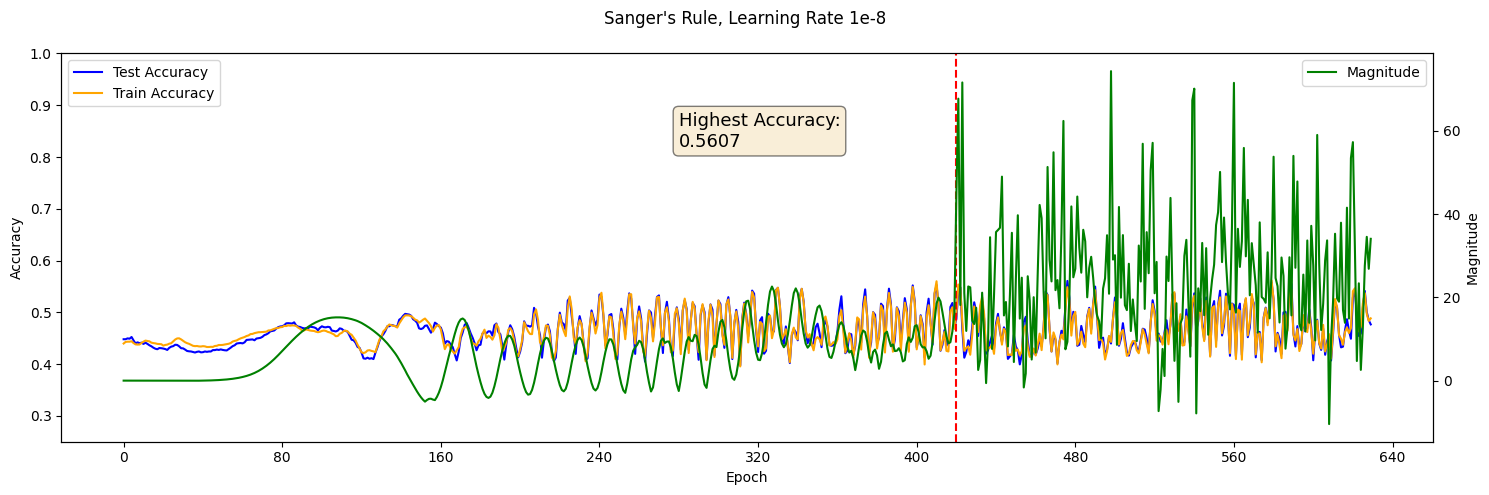

In [68]:
his1 = history_oja_lr_1e4_wd_1e5
his2 = history_oja_lr_1e5_wd_1e5
# replace mangitude nan with 1e30
for i in range(len(his1)):
    if np.isnan(his1[i]['magnitude']):
        his1[i]['magnitude'] = 1e35

for i in range(len(his2)):
    if np.isnan(his2[i]['magnitude']):
        his2[i]['magnitude'] = 1e35

fig, (ax1, ax3) = plt.subplots(1, 2)
fig.suptitle('Oja\'s Rule, Learning Rate 1e-4 and 1e-5, Weight Decay 1e-5')
# make the size 3:1
fig.set_size_inches(15, 5)

# First subplot using history_lr_1e8 data
test_accuracy = [x['test_accuracy'] for x in his1]
train_accuracy = [x['train_accuracy'] for x in his1]
magnitude = [x['magnitude'] for x in his1]

title = "Learning Rate 1e-4"

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to only show integers
ax1.set_title(title)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.plot(test_accuracy, label='Test Accuracy', color='blue')
ax1.plot(train_accuracy, label='Train Accuracy', color='orange')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
lims = [0.25, 1.0]
ax1.set_ylim(lims)

largest_test_accuracy = max(test_accuracy)

# add this in a little box in the middle right
text = f"Highest Accuracy:\n{largest_test_accuracy:.4f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.72, 0.75, text, transform=ax1.transAxes, fontsize=13,
        verticalalignment='bottom', bbox=props)


ax2 = ax1.twinx()
ax2.set_ylabel('Magnitude')
ax2.plot(magnitude, label='Magnitude', color='green')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')
# y is log

# Second subplot using history_lr_1e7 data
# the x axis is 0-10
test_accuracy = [x['test_accuracy'] for x in his2]
train_accuracy = [x['train_accuracy'] for x in his2]
magnitude = [x['magnitude'] for x in his2]

title = "Learning Rate 1e-5"

ax3.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to only show integers
ax3.set_title(title)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.plot(test_accuracy, label='Test Accuracy', color='blue')
ax3.plot(train_accuracy, label='Train Accuracy', color='orange')
ax3.tick_params(axis='y')
ax3.legend(loc='upper left')
ax3.set_ylim(lims)

largest_test_accuracy = max(test_accuracy)
text = f"Highest Accuracy:\n{largest_test_accuracy:.4f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax3.text(0.72, 0.75, text, transform=ax3.transAxes, fontsize=13,
        verticalalignment='bottom', bbox=props)


ax4 = ax3.twinx()
ax4.set_ylabel('Magnitude')
ax4.plot(magnitude, label='Magnitude', color='green')
ax4.tick_params(axis='y')
ax4.legend(loc='upper right')

fig.tight_layout()
plt.show()

This model starts diverging really quickly. Maybe using a simpler model could help here.

In the hebbian update method, there is no mechanism to prevent weights from diverging. Such a mechanism is offered by Oja's rule, which is a variant of Hebb's rule, in which there is an extra normalization step that scales the weight updates. Hebb's rule has synaptic weights approaching infinity with a positive learning rate. We can stop this by normalizing the weights so that each weight's magnitude is restricted between 0, corresponding to no weight, and 1, corresponding to being the only input neuron with any weight. We do this by normalizing the weight vector to be of length one: 

In [ ]:
def sanger_update(weights, activations, learning_rate=0.01):
    # Sanger's rule: ΔW = η * Y * (X - W * Y)
    # X is the pre-synaptic activation (input), Y is the post-synaptic activation (output),
    # W is the weights, and η is the learning rate

    # Vectorized computation for the sums
    cumulative_weights = torch.cumsum(weights, dim=0)
    weighted_sums = torch.matmul(cumulative_weights.T, activations[1].unsqueeze(1)).squeeze()

    sums = activations[1].unsqueeze(1) * (activations[0] - weighted_sums)

    # Update weights
    return weights + learning_rate * sums

$\Delta W_{ij} = \eta \cdot y_i \cdot \left( x_j - \sum_{k=1}^{i} y_k \cdot W_{kj} \right)$


Epoch 1 - Test accuracy: 0.5185, Train accuracy: 0.5213 - Magnitude: 0.06613162159919739, Time: 4.156503915786743
Epoch 2 - Test accuracy: 0.507, Train accuracy: 0.512 - Magnitude: 0.2635684609413147, Time: 4.346840143203735
Epoch 3 - Test accuracy: 0.507, Train accuracy: 0.5095 - Magnitude: 0.6824056506156921, Time: 4.532817840576172
Epoch 4 - Test accuracy: 0.509, Train accuracy: 0.5104 - Magnitude: 1.1320934295654297, Time: 4.695864915847778
Epoch 5 - Test accuracy: 0.5175, Train accuracy: 0.5142 - Magnitude: 1.6767587661743164, Time: 4.581799745559692
Epoch 6 - Test accuracy: 0.538, Train accuracy: 0.5247 - Magnitude: 2.491764545440674, Time: 4.440593957901001
Epoch 7 - Test accuracy: 0.5635, Train accuracy: 0.5477 - Magnitude: 2.9594435691833496, Time: 4.577192783355713
Epoch 8 - Test accuracy: 0.5385, Train accuracy: 0.5438 - Magnitude: 1.9071694612503052, Time: 4.403748512268066
Epoch 9 - Test accuracy: 0.511, Train accuracy: 0.5221 - Magnitude: -0.6372613310813904, Time: 4.2037

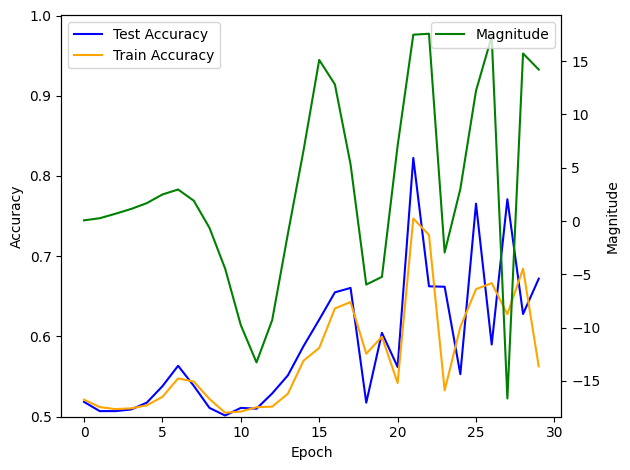

In [ ]:
net = FullyConnectedNN([32*32*3, 100, 2], activation=nn.ReLU())
# initialize weights
net.to(device)

plot_accuracy_magnitude(hebbian_train(net, x_train, y_train, epochs=30, learning_rate=1e-7, update_rule=sanger_update, weight_decay=1e-6))

There seems to be a corelation between the magnitude of the weights and the accuracy. Let's repeat the experiment above but lower the weight decay.

Epoch 1 - Test accuracy: 0.7955, Train accuracy: 0.7932 - Magnitude: 0.5558423399925232, Time: 2.6273117065429688
Epoch 2 - Test accuracy: 0.772, Train accuracy: 0.775 - Magnitude: 1.5766185522079468, Time: 2.6827237606048584
Epoch 3 - Test accuracy: 0.7545, Train accuracy: 0.7572 - Magnitude: 4.815824508666992, Time: 2.7462782859802246
Epoch 4 - Test accuracy: 0.75, Train accuracy: 0.7474000000000001 - Magnitude: 13.95120906829834, Time: 2.6941492557525635
Epoch 5 - Test accuracy: 0.7505, Train accuracy: 0.7449 - Magnitude: 25.568286895751953, Time: 2.6818203926086426
Epoch 6 - Test accuracy: 0.7505, Train accuracy: 0.7443 - Magnitude: 28.71391487121582, Time: 2.809563636779785
Epoch 7 - Test accuracy: 0.751, Train accuracy: 0.7449 - Magnitude: 28.983102798461914, Time: 2.7547919750213623
Epoch 8 - Test accuracy: 0.7505, Train accuracy: 0.7457 - Magnitude: 28.968751907348633, Time: 2.7547130584716797
Epoch 9 - Test accuracy: 0.752, Train accuracy: 0.7468 - Magnitude: 28.94020462036132

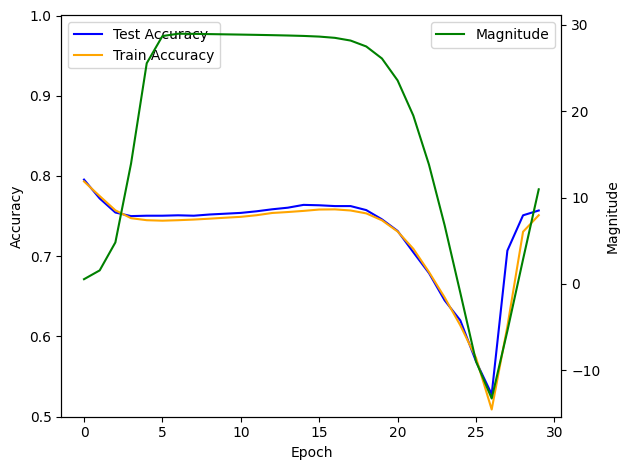

In [ ]:
net = FullyConnectedNN([32*32*3, 2], activation=nn.ReLU())
# initialize weights
net.to(device)

plot_accuracy_magnitude(hebbian_train(net, x_train, y_train, epochs=30, learning_rate=1e-7, update_rule=sanger_update, weight_decay=1e-7))

Intrestingly, the model seems to not benefit from increased complexity.

In [85]:
x_train_pca = pcas[7].transform(x_train)
x_test_pca = pcas[7].transform(x_test)

n_components = x_train_pca.shape[1]

net = FullyConnectedNN([n_components, n_components//2, n_components//4, n_components//16, 2], activation=nn.ReLU())
net.to(device)

plot_accuracy_magnitude(hebbian_train(net, x_train_pca, y_train, x_test_pca, y_test, epochs=30, learning_rate=1e-5, update_rule=sanger_update, weight_decay=1e-3))

NameError: name 'pcas' is not defined

In [ ]:
print(net)

FullyConnectedNN(
  (layers): ModuleList(
    (0): Linear(in_features=265, out_features=132, bias=True)
    (1): ReLU()
    (2): Linear(in_features=132, out_features=66, bias=True)
    (3): ReLU()
    (4): Linear(in_features=66, out_features=33, bias=True)
    (5): ReLU()
    (6): Linear(in_features=33, out_features=2, bias=True)
  )
)


### Comparing with KNN, NNC

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=1)

x_train_knn = x_train[:1000]
y_train_knn = y_train[:1000]

x_test_knn = x_test[:400]
y_test_knn = y_test[:400]

pca = pcas[5]

x_train_knn = pca.transform(x_train_knn)
x_test_knn = pca.transform(x_test_knn)

knn_1.fit(x_train_knn, y_train_knn)

y_pred = knn_1.predict(x_test_knn)

# Calculate and store the accuracy of the model on both train and test set
accuracy_test = accuracy_score(y_pred, y_test_knn)

print(f'Accuracy on test set: {accuracy_test:.2f}')

Accuracy on test set: 0.79


In [ ]:
knn_3 = KNeighborsClassifier(n_neighbors=3)

x_train_knn = x_train[:1000]
y_train_knn = y_train[:1000]

x_test_knn = x_test[:400]
y_test_knn = y_test[:400]

pca = pcas[5]

x_train_knn = pca.transform(x_train_knn)
x_test_knn = pca.transform(x_test_knn)

knn_3.fit(x_train_knn, y_train_knn)

y_pred = knn_3.predict(x_test_knn)

# Calculate and store the accuracy of the model on both train and test set
accuracy_test = accuracy_score(y_pred, y_test_knn)

print(f'Accuracy on test set: {accuracy_test:.2f}')

Accuracy on test set: 0.77


In [ ]:
nn = NearestCentroid()

x_train_nn = x_train[:1000]
y_train_nn = y_train[:1000]

x_test_nn = x_test[:400]
y_test_nn = y_test[:400]

pca = pcas[5]

x_train_nn = pca.transform(x_train_nn)
x_test_nn = pca.transform(x_test_nn)

nn.fit(x_train_nn, y_train_nn)

y_pred = nn.predict(x_test_nn)

# Calculate and store the accuracy of the model on both train and test set
accuracy_test = accuracy_score(y_pred, y_test_nn)

print(f'Accuracy on test set: {accuracy_test:.2f}')

Accuracy on test set: 0.72


The accuracy using `PCA -> KNN / NN` is very high, almost as high as that of the original SVM (~81%). This is unexpected yet interesting, as it shows `PCA`'s strength in "understanding" the data.

### Thank you for your attention!